# DepMap CNV and dependency exploration

This notebook loads and analyzes the DepMap copy number and dependency effect data to explore how much of the proximity bias effect can be attributed to copy number variation.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import pickle

import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from multiprocessing import Pool

# Importing locally here, but the prox bias and efaar_benchmarking packages are available through Nexus
module_path = os.path.abspath(os.path.join("../../../proxbias"))
if module_path not in sys.path:
    sys.path.insert(0, module_path)
module_path = os.path.abspath(os.path.join("../../../EFAAR_benchmarking"))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# This is necesary for the svg output plots to have editable text
plt.rcParams["svg.fonttype"] = "none"

# This isn't necessary it's just to make the notebook take up full screen real estate
from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
path = "depmap_cnv_scratch"
if not os.path.exists(path):
    os.mkdir(path)

# Download data

The `get_depmap_data` function downloads data and caches locally

`DepMap Public 22Q4` cell line annotation (CNV & mutations) and dependency data as well as RNAi data from `DEMETER2 Data v6`

Descriptions are in the README files from DepMap at `https://depmap.org/portal/download/all/`

In [3]:
from proxbias.depmap.load import get_depmap_data

In [4]:
%%time
crispr_effect, rnai_effect, cnv_data, mutation_data = get_depmap_data()
crispr_effect.index.name = "gene"

CRISPRGeneEffect.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
D2_combined_gene_dep_scores.csv from DEMETER2 Data v6 is found. Reading dataframe from cache.
Done!
OmicsCNGene.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
OmicsSomaticMutations.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
CPU times: user 34.3 s, sys: 754 ms, total: 35 s
Wall time: 35.5 s


In [57]:
print(f"{rnai_effect.shape[1]} cell lines for RNAi data")

190 cell lines for RNAi data


# Explore CNV data

In [5]:
from proxbias import utils

### Subset to genes with chrom information from hg38 and in the dependency data

In [6]:
gene_dict, chrom_dict, band_dict = utils.chromosome_info.get_chromosome_info_as_dicts()
genes = list(gene_dict.keys())

In [7]:
cnv_data.index.name = "gene"
idx = cnv_data.query(f"gene.isin({genes})").index
print(f"CNV data has {cnv_data.shape[0]} genes, {len(idx)} of which are in the hg38 annotations")
cnv_data = cnv_data.loc[idx]

dm_genes = list(crispr_effect.index.get_level_values("gene").unique())
idx = cnv_data.query(f"gene.isin({dm_genes})").index
print(f"CNV data has {cnv_data.shape[0]} genes, {len(idx)} of which are in the DepMap annotations")
cnv_data = cnv_data.loc[idx]

CNV data has 25368 genes, 24171 of which are in the hg38 annotations
CNV data has 24171 genes, 17315 of which are in the DepMap annotations


### Subset to cell lines in the dependency data

In [11]:
dep_cls = list(crispr_effect.columns)
cnv_cls = list([x for x in cnv_data.columns if x in dep_cls])
print(f"CNV data has {cnv_data.shape[1]} cell lines, {len(cnv_cls)} of which are in the dependency data")
cnv_data = cnv_data.loc[:, cnv_cls]

CNV data has 1775 cell lines, 1078 of which are in the dependency data


### Add chromosome position information to the CNV data

In [12]:
# Add in chromomsome information
def _add_chr_info(df, gene_dict, in_nm, out_nm):
    df[out_nm] = df.index.to_frame().gene.apply(lambda x: gene_dict[x][in_nm] if x in gene_dict else "no_info")
    return df


def add_chr_info(df, gene_dict):
    # Subset to genes with chrom information from hg38
    genes = list(gene_dict.keys())
    idx = df.query(f"gene.isin({genes})").index
    print(f"Full data has {df.shape[0]} genes, {len(idx)} of which are in annotations")
    df = df.loc[idx]

    df = _add_chr_info(df, gene_dict, "chrom", "chromosome")
    df = _add_chr_info(df, gene_dict, "chrom_int", "chr_idx")
    df = _add_chr_info(df, gene_dict, "arm", "chromosome_arm")
    df = _add_chr_info(df, gene_dict, "start", "gene_bp")

    cols = ["gene", "chromosome", "chr_idx", "chromosome_arm", "gene_bp"]
    return df.reset_index().set_index(cols).sort_values(["chr_idx", "gene_bp"])

In [13]:
cnv_data = add_chr_info(cnv_data, gene_dict)
cnv_data.iloc[:5, :5]

Full data has 17315 genes, 17315 of which are in annotations


,,,,ModelID,ACH-000681,ACH-000769,ACH-000853,ACH-001338,ACH-000276
gene,chromosome,chr_idx,chromosome_arm,gene_bp,,,,,
SAMD11,chr1,1,chr1p,923922,0.775472,0.831376,1.083618,0.566967,0.671167
NOC2L,chr1,1,chr1p,944202,0.775472,0.831376,1.083618,0.566967,0.671167
KLHL17,chr1,1,chr1p,960583,0.775472,0.831376,1.083618,0.566967,0.671167
PLEKHN1,chr1,1,chr1p,966481,0.775472,0.831376,1.083618,0.566967,0.671167
HES4,chr1,1,chr1p,998963,0.775472,0.831376,1.083618,0.566967,0.671167


### Transform from pseudo counts to actual copy number calls

In [14]:
cnv_data_trans = 2 * (np.power(2, cnv_data) - 1)

### Plot CNV tracks for the first 5 cell lines

In [15]:
def plot_wg_tracks(df, show_chr_lines=True, show_cent_lines=True, show_chroms=True):
    for i in range(df.shape[1]):
        plt.scatter(np.arange(df.shape[0]), df.values[:, i], s=1, label=df.columns[i])

    if show_chr_lines or show_chroms or show_cent_lines:
        # Get the position of all the chromosomes and centromeres
        index_df = df.index.to_frame(index=False).reset_index().rename({"index": "pos"}, axis=1)
        chr_pos = index_df.groupby("chromosome").pos.max().sort_values()
        cent_pos = index_df.groupby("chromosome_arm").pos.max().sort_values()
        # Filter to just p-arms
        cent_pos_p = cent_pos[[x[-1] == "p" for x in cent_pos.index]]
        # Get midpoints for annotations
        chr_mids = pd.DataFrame(
            (np.insert(chr_pos.values[:-1], 0, 0) + chr_pos.values) / 2, index=chr_pos.index
        ).to_dict()[0]
        cent_mids = pd.DataFrame(
            (np.insert(cent_pos.values[:-1], 0, 0) + cent_pos.values) / 2, index=cent_pos.index
        ).to_dict()[0]

    # Hide X and Y axes label marks
    ax = plt.gca()
    ax.xaxis.set_tick_params(labelbottom=False)
    # Hide X and Y axes tick marks
    ax.set_xticks([])

    xm, xM = ax.get_xlim()
    ym, yM = ax.get_ylim()

    if show_chr_lines:
        for x in chr_pos.values:
            plt.plot([x + 0.5, x + 0.5], [ym, yM], color="k", ls="-", lw=1)
    if show_cent_lines:
        for x in cent_pos_p.values:
            plt.plot([x + 0.5, x + 0.5], [ym, yM], color="k", ls=":", lw=1)

    if show_chroms:
        # Label chromosomes on top/right to not clash with coords
        ax = plt.gca()
        for ch in chr_mids:
            # Labels across the bottom
            label_locy = ym - (yM - ym) * 0.1
            ax.text(chr_mids[ch], label_locy, ch.replace("chr", ""), ha="center", va="bottom", rotation=0, size=12)
    ax.set_facecolor("white")

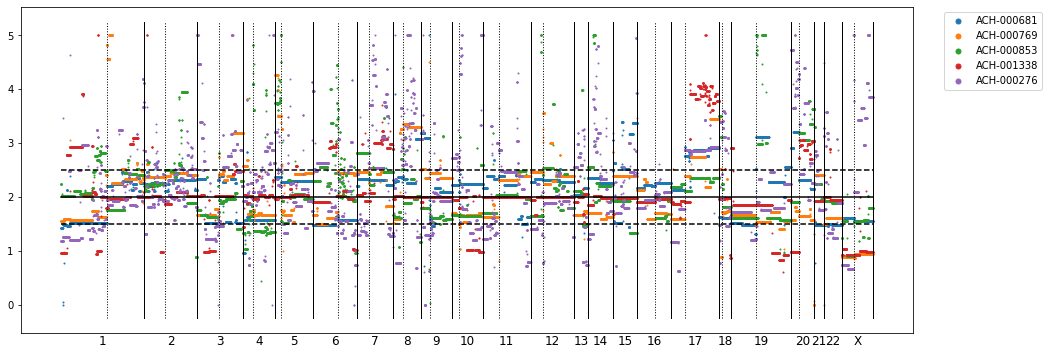

In [16]:
plt.figure(figsize=(16, 6))
df = cnv_data_trans.iloc[:, :5].clip(0, 5)
plot_wg_tracks(df)
mid = 2
plt.plot((0, df.shape[0]), (mid, mid), "-", c="k")
plt.plot((0, df.shape[0]), (mid + 0.5, mid + 0.5), "--", c="k")
plt.plot((0, df.shape[0]), (mid - 0.5, mid - 0.5), "--", c="k")
plt.legend(bbox_to_anchor=(1.15, 1), markerscale=5);

## Make a proximity bias map just using copy number annotations

There's a very strong chromosome-arm based signal here.
The DepMap team corrected the dependency data for CNV effects using the "Chronos" pipeline here:
https://github.com/broadinstitute/chronos/blob/master/chronos/copy_correction.py. 
Citation: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02540-7

Explanation:
"To remove copy number bias, Chronos provides a function that accepts a matrix of gene-level copy number (processed as in DepMap: log2(x + 1) where x is the relative copy number) and a matrix of gene fitness effect. It constructs a two-dimensional cubic spline representation for each gene fitness effect score in each cell line, where the first dimension is the copy number of the gene in a given line and the second is the mean effect of the gene across lines."

Note: We're not quantile normalizing these data because the distribution is skewed with a heavy upper tail, so forcing it to fit a Gaussian distribution creates distortions.

In [14]:
from proxbias.utils.df_tools import make_pairwise_cos
from proxbias.plotting.heatmaps import plot_heatmap

In [15]:
%%time
# Center rows
cnv_data_cent = cnv_data.sub(cnv_data.mean(axis=1), axis=0)
cnv_wg_mat = make_pairwise_cos(cnv_data_cent)

CPU times: user 2min 49s, sys: 656 ms, total: 2min 50s
Wall time: 2min 50s


CNV similarity heatmap


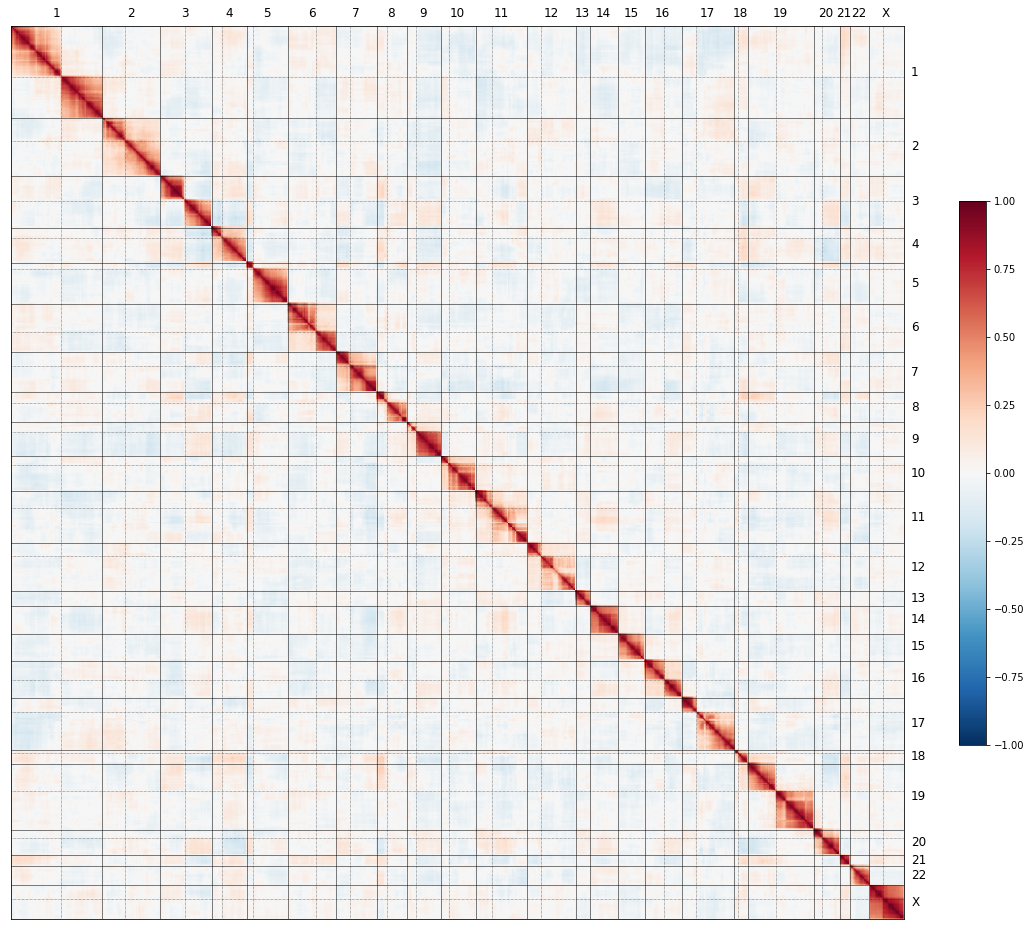

In [16]:
print("CNV similarity heatmap")
plot_heatmap(cnv_wg_mat, f_name=os.path.join(path, "DepMap_22Q4_CNV_map.svg"), format="svg", crunch_factor=20, title="")

CNV similarity heatmap Chr1


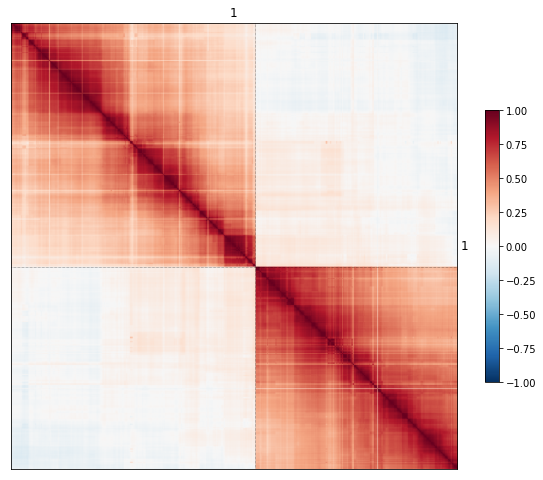

In [17]:
print("CNV similarity heatmap Chr1")
idx = cnv_wg_mat.query('chromosome=="chr1"').index
plot_heatmap(
    cnv_wg_mat.loc[idx, idx],
    f_name=os.path.join(path, "DepMap_22Q4_CNV_map_chr1.svg"),
    figsize=(10, 10),
    format="svg",
    crunch_factor=1,
    title="",
)

# Dependency data

In [18]:
# Add chromosome position information
crispr_effect = add_chr_info(crispr_effect, gene_dict)

Full data has 17453 genes, 17396 of which are in annotations


### Center data by rows (genes) 
This makes the dependency data more comparable between genes. Note that centering per gene and using cosine similarity is equivalent to using Pearson correlation between dependency values.

In [19]:
crispr_effect_cent = crispr_effect.sub(crispr_effect.mean(axis=1), axis=0)

In [20]:
crispr_effect_cent.iloc[:2, :10]

,,,,ModelID,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017
gene,chromosome,chr_idx,chromosome_arm,gene_bp,,,,,,,,,,
SAMD11,chr1,1,chr1p,923922,0.138971,-0.024604,0.164436,-0.135659,0.181989,-0.007635,0.050045,-0.001966,0.05847,-0.058567
NOC2L,chr1,1,chr1p,944202,-0.337622,0.298930,-0.277252,-0.199345,0.045464,-0.445447,0.153700,-0.053124,0.14612,-0.107405


## Make a split heatmap with dependency and CNV data

In [21]:
from proxbias.utils.q_norm import q_norm
from proxbias.utils.df_tools import make_split_cosmat

In [22]:
# Subset dependency data to genes in the CNV data
intersect_genes = np.intersect1d(
    cnv_data_cent.index.get_level_values("gene"), crispr_effect_cent.index.get_level_values("gene")
)
crispr_effect_cent2 = crispr_effect_cent.query("gene in @intersect_genes")
print("CNV data:", cnv_data_cent.shape, "Dependency data:", crispr_effect_cent2.shape)

CNV data: (17315, 1078) Dependency data: (17315, 1078)


In [23]:
%%time
# Make pairwise
crispr_effect_cent_mat = make_pairwise_cos(crispr_effect_cent2)
# Quantile normalize
crispr_effect_cent_mat_norm = q_norm(crispr_effect_cent_mat)
print("dm22q4_cent2 shape:", crispr_effect_cent_mat_norm.shape)

dm22q4_cent2 shape: (17315, 17315)
CPU times: user 6min 13s, sys: 3.01 s, total: 6min 16s
Wall time: 6min 16s


DepMap 22Q4 gene effect quantile normalized (upper) -- CNV not quantile normalized (lower)


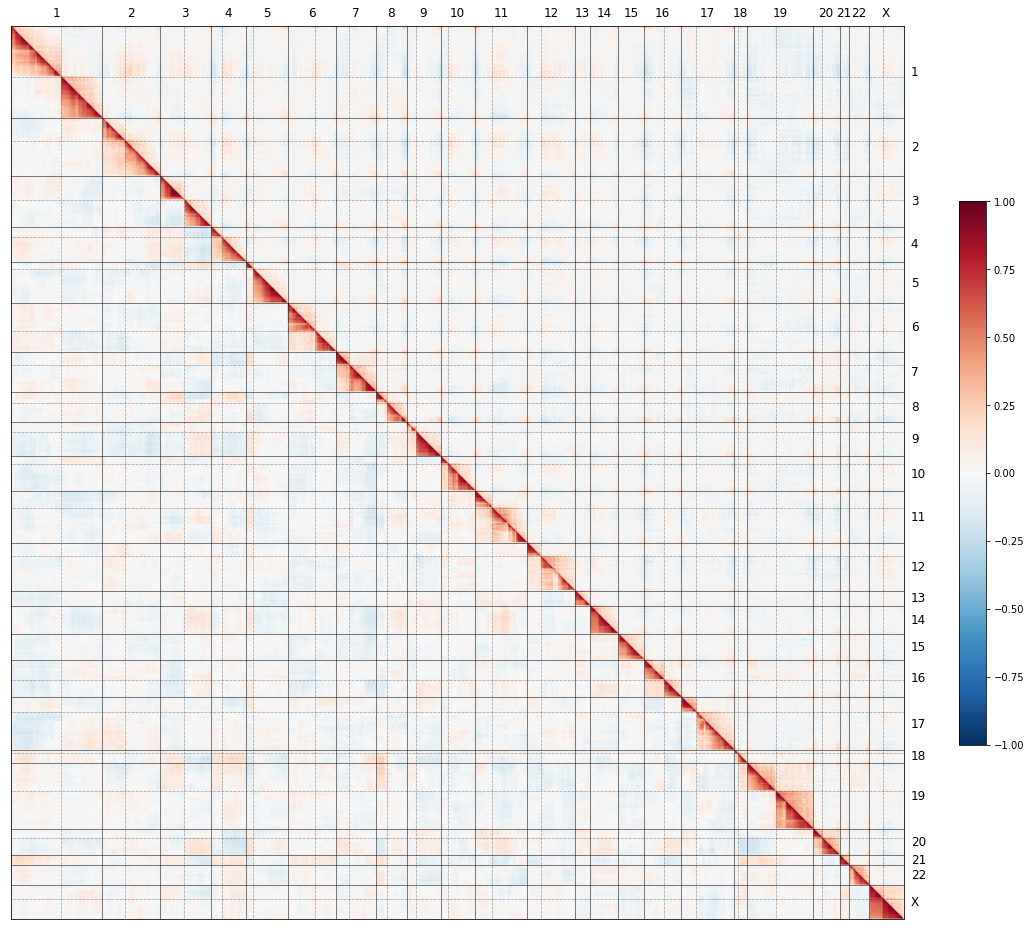

In [24]:
# Make split heatmap
idx = crispr_effect_cent_mat_norm.index
crispr_effect_cnv_split_mat = make_split_cosmat(crispr_effect_cent_mat_norm, cnv_wg_mat.loc[idx, idx])
print("DepMap 22Q4 gene effect quantile normalized (upper) -- CNV not quantile normalized (lower)")
plot_heatmap(
    crispr_effect_cnv_split_mat,
    f_name=os.path.join(path, "DepEffect_vs_CVN_split.svg"),
    format="svg",
    crunch_factor=10,
    title="",
)

# There's clearly a big proximity bias effect in the copy number data.  
To tease this apart from the signal we see in the dependency data, we try two approaches:

- 1) Look at proximity bias in the dependency data for cell lines with few copy number changes.
  - A few caveats here are that we might just see less signal over all and cell lines without copy number variants might also have better DNA repair and therefore be less prone to proximity bais (since we believe it's driven by large truncations).
- 2) Make mini-maps for each pair of chromosome arms subsetting to cell lines with out CNVs on those arms.

## Look for cell lines with the least copy number changes

For each cell line

- Count the number of genes with copy number outside of [1.75, 2.25] (excluding X and Y)
- Look for cell lines with the lowest percentage of genes with CN outisde of that range

In [25]:
cnv_calls = (cnv_data_trans < 1.75) | (cnv_data_trans > 2.25)
cnv_call_pers = cnv_calls.query('chromosome not in ("chrX", "chrY")').mean(axis=0).sort_values(ascending=False)

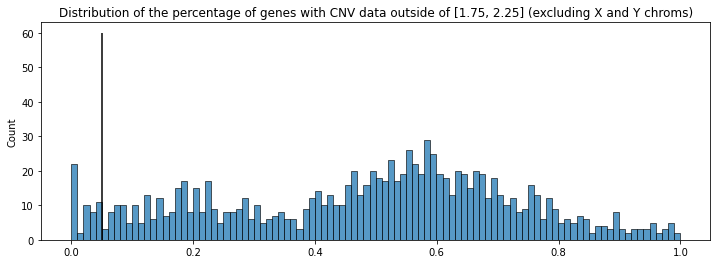

In [26]:
plt.figure(figsize=(12, 4))
plt.title("Distribution of the percentage of genes with CNV data outside of [1.75, 2.25] (excluding X and Y chroms)")
ax = sns.histplot(cnv_call_pers, bins=100)
plt.vlines(x=0.05, ymin=0, ymax=60, color="k");

In [27]:
least_cnv_cl_01 = list(cnv_call_pers[cnv_call_pers < 0.01].index)
print(f"{len(least_cnv_cl_01)} cell lines have less that 1% of genes with copy number outside of [1.75, 2.25])")

21 cell lines have less that 1% of genes with copy number outside of [1.75, 2.25])


In [28]:
least_cnv_cl_05 = list(cnv_call_pers[cnv_call_pers < 0.05].index)
print(f"{len(least_cnv_cl_05)} cell lines have less that 5% of genes with copy number outside of [1.75, 2.25])")

53 cell lines have less that 5% of genes with copy number outside of [1.75, 2.25])


### CNV plot of the cell lines with less that 1% of gene having CN outside of [1.75, 2.25] (excluding X and Y)

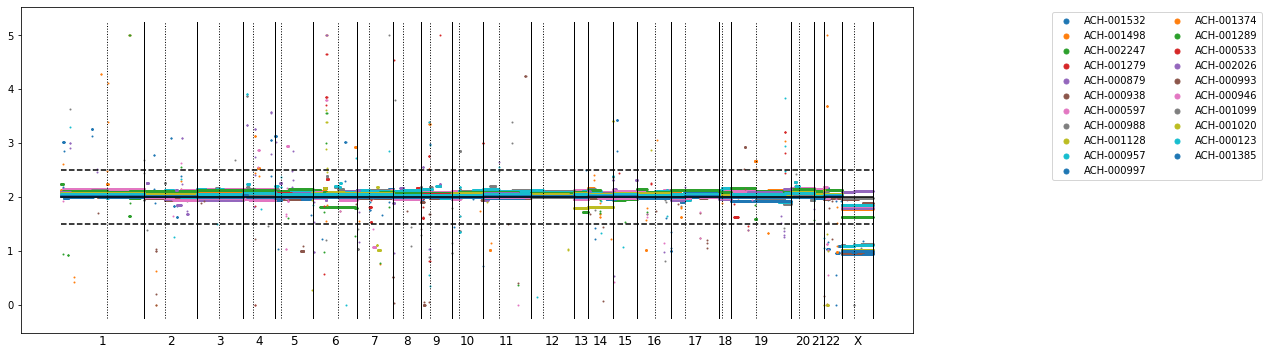

In [29]:
plt.figure(figsize=(16, 6))
df = cnv_data_trans.loc[:, least_cnv_cl_01].clip(0, 5)
plot_wg_tracks(df)
mid = 2
plt.plot((0, df.shape[0]), (mid, mid), "-", c="k")
plt.plot((0, df.shape[0]), (mid + 0.5, mid + 0.5), "--", c="k")
plt.plot((0, df.shape[0]), (mid - 0.5, mid - 0.5), "--", c="k")
plt.legend(bbox_to_anchor=(1.15, 1), markerscale=5, ncol=2);

### CNV plot of the cell lines with less that 5% of gene having CN outside of [1.75, 2.25] (excluding X and Y)
This is maybe too loose, a cell line could have a whole chromosome amplified/deleted.

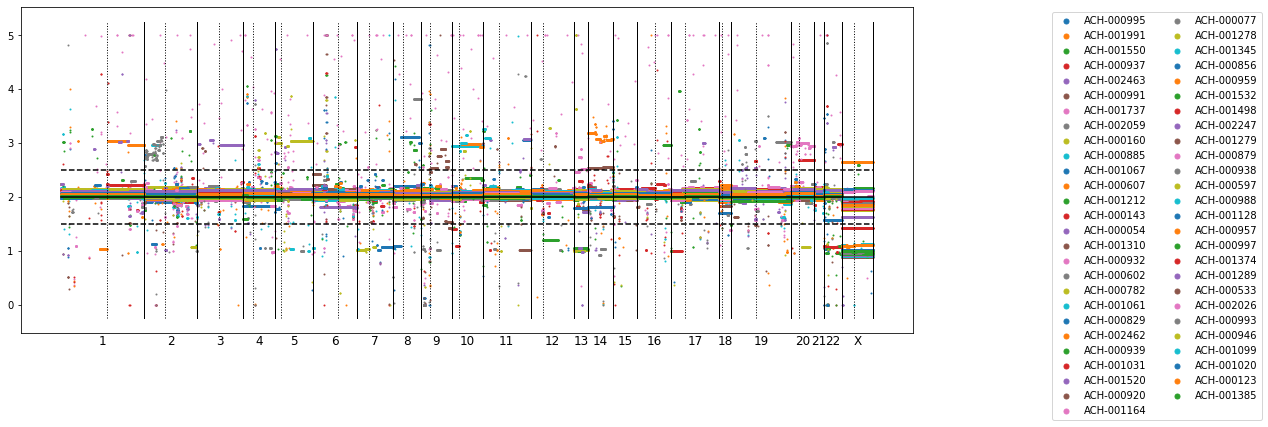

In [30]:
plt.figure(figsize=(16, 6))
df = cnv_data_trans.loc[:, least_cnv_cl_05].clip(0, 5)
plot_wg_tracks(df)
mid = 2
plt.plot((0, df.shape[0]), (mid, mid), "-", c="k")
plt.plot((0, df.shape[0]), (mid + 0.5, mid + 0.5), "--", c="k")
plt.plot((0, df.shape[0]), (mid - 0.5, mid - 0.5), "--", c="k")
plt.legend(bbox_to_anchor=(1.15, 1), markerscale=5, ncol=2);

### Zoom in on [1.5, 2.5] for 1% data

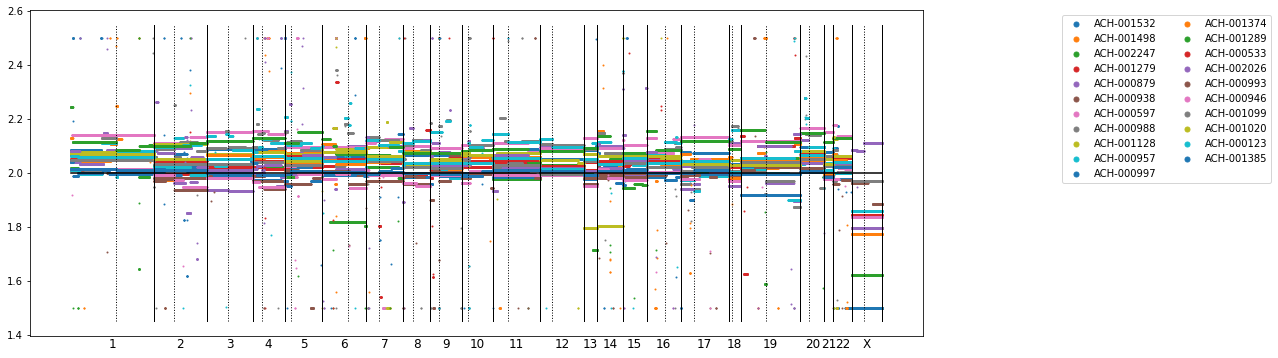

In [31]:
plt.figure(figsize=(16, 6))
df = cnv_data_trans.loc[:, least_cnv_cl_01].clip(1.5, 2.5)
plot_wg_tracks(df)
mid = 2
plt.plot((0, df.shape[0]), (mid, mid), "-", c="k")
plt.legend(bbox_to_anchor=(1.15, 1), markerscale=5, ncol=2);

## Look at prox bias in the dependency data when building the map from the cell lines with fewest CNVs (< 1% of genes)

In [32]:
from proxbias.metrics import bm_metrics
from proxbias.plotting.bm_bars import plot_bm_arm_bars, plot_bm_bar_pairs

/mnt/ps/home/CORP/nathan.lazar/.pyenv/versions/tatooine/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [33]:
%%time
crispr_effect_mat = make_pairwise_cos(crispr_effect_cent)

CPU times: user 2min 48s, sys: 696 ms, total: 2min 49s
Wall time: 2min 49s


In [34]:
crispr_effect_bm_all, crispr_effect_bm_arm = bm_metrics(crispr_effect_mat, verbose=False, sample_frac=0.1)

In [35]:
%%time
least_cnv_dep_mat_01 = make_pairwise_cos(crispr_effect_cent.loc[:, least_cnv_cl_01])
least_cnv_dep_mat_05 = make_pairwise_cos(crispr_effect_cent.loc[:, least_cnv_cl_05])

CPU times: user 10.9 s, sys: 1.36 s, total: 12.2 s
Wall time: 12.2 s


In [36]:
least_cnv_bm_metrics = {"0.01": {}, "0.05": {}}
least_cnv_bm_metrics["0.01"]["all"], least_cnv_bm_metrics["0.01"]["arm"] = bm_metrics(
    least_cnv_dep_mat_01, verbose=False, sample_frac=0.1
)
least_cnv_bm_metrics["0.05"]["all"], least_cnv_bm_metrics["0.05"]["arm"] = bm_metrics(
    least_cnv_dep_mat_05, verbose=False, sample_frac=0.1
)

### Prox bias is signficiantly reduced by filtering to cell lines without CNVs, but there is some still present
This is also confounded by having many fewer cell lines, so there may just be less signal there overall. 

Also, we may expect that DepMap cell lines without any CNVs are also less susceptible to proximity bias because their DNA repair mechanisms are robust.

In [37]:
pd.concat(
    [crispr_effect_bm_all, least_cnv_bm_metrics["0.05"]["all"], least_cnv_bm_metrics["0.01"]["all"]],
    keys=["all", "least_cnv_05", "least_cnv_01"],
)

,,stat,prob,pval,n_within,n_between
all,all,1872.125646,0.747557,0.0,4558965,29348528
least_cnv_05,all,276.439654,0.540201,0.0,4558965,29348528
least_cnv_01,all,180.067593,0.526194,0.0,4558965,29348528


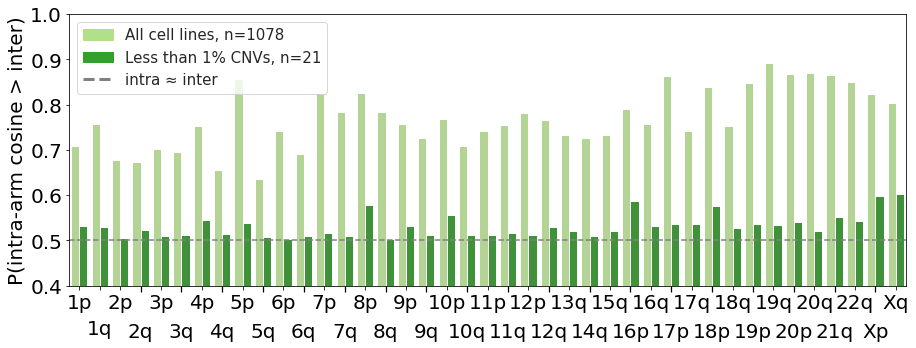

In [38]:
tmp = (
    pd.concat([crispr_effect_bm_arm, least_cnv_bm_metrics["0.01"]["arm"]], keys=["all", "least_cnv_01"])
    .reset_index()
    .rename({"level_1": "Chromosome arm", "level_0": "Condition", "prob": "P(intra-arm cosine > inter)"}, axis=1)
)
plot_bm_bar_pairs(
    tmp,
    x="Chromosome arm",
    y="P(intra-arm cosine > inter)",
    hue="Condition",
    lab1=f"All cell lines, n={cnv_data_trans.shape[1]}",
    lab2=f"Less than 1% CNVs, n={len(least_cnv_cl_01)}",
    i=1,
    legend_loc="upper left",
    f_name=os.path.join(path, "chr12q_split_bars_arm.svg"),
)

# Look at prox bias for pairs of arms that are concordant in copy number

We subset cell lines to have few CNVs (< 1%) on all pairs of chromosome arms and calculate whithin-vs-between probabilities for just that pair of arms. Then make a heatmap across all pairs.

Proceedure:
- For each pair (ignoring X)
  - Subset to the cell lines with no CNVs on that pair of arms
  - Create a map with just the two chromosome arms
  - Calculate arm-level BM stats for just those two arms (gene pairs will all be concordant in copy number)
  - Save that stat for both arms
  - Plot that heatmap

In [39]:
ARMS_ORD = (
    "chr1p,chr1q,chr2p,chr2q,chr3p,chr3q,chr4p,chr4q,chr5p,chr5q,chr6p,"
    "chr6q,chr7p,chr7q,chr8p,chr8q,chr9p,chr9q,chr10p,chr10q,chr11p,chr11q,"
    "chr12p,chr12q,chr13q,chr14q,chr15q,chr16p,chr16q,chr17p,chr17q,chr18p,"
    "chr18q,chr19p,chr19q,chr20p,chr20q,chr21q,chr22q,chrXp,chrXq"
).split(",")

In [40]:
no_cnv_pairs_n = pd.DataFrame(np.zeros(shape=(len(ARMS_ORD), len(ARMS_ORD))), index=ARMS_ORD, columns=ARMS_ORD).astype(
    int
)
no_cnv_pairs = {}

In [41]:
# Select cell lines where the pair of arms is copy number normal
for arm1, arm2 in combinations(ARMS_ORD, 2):
    pair = tuple(sorted([arm1, arm2]))
    q = "<=0.01 and ".join(pair) + "<=0.01"

    cls = list(cnv_calls.groupby("chromosome_arm").mean().T.query(q).index)
    no_cnv_pairs[pair] = cls
    no_cnv_pairs_n.loc[arm1, arm2] = len(cls)
    no_cnv_pairs_n.loc[arm2, arm1] = len(cls)

In [42]:
no_cnv_pairs_n.to_parquet(os.path.join(path, "no_cnv_pairs_n.pq"))

Number of cell lines with <1% cnvs on both arms


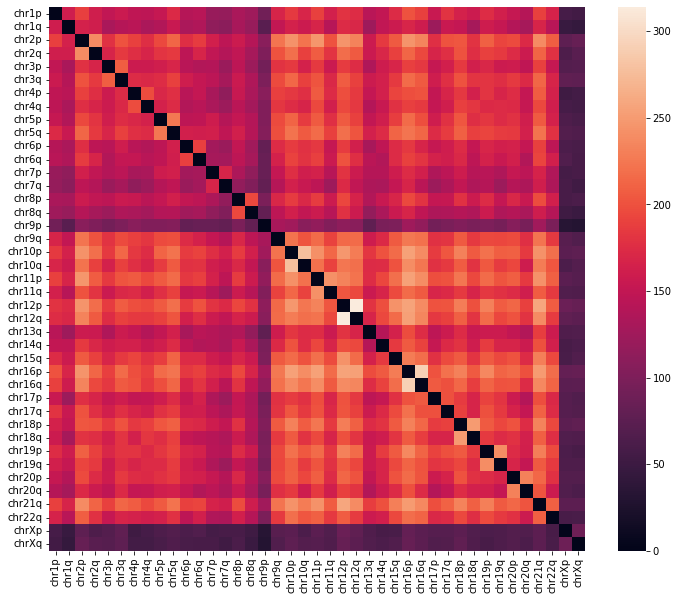

In [43]:
print("Number of cell lines with <1% cnvs on both arms")
plt.figure(figsize=(12, 10))
sns.heatmap(no_cnv_pairs_n);

In [44]:
print("min:", np.min(no_cnv_pairs_n.values[np.triu_indices(no_cnv_pairs_n.shape[0] - 2, 1)]))
print("mean:", np.mean(no_cnv_pairs_n.values[np.triu_indices(no_cnv_pairs_n.shape[0] - 2, 1)]))
print("max:", np.max(no_cnv_pairs_n.values[np.triu_indices(no_cnv_pairs_n.shape[0] - 2, 1)]))

min: 73
mean: 173.54925775978407
max: 314


In [45]:
ARMS_ORD_NOX = (
    "chr1p,chr1q,chr2p,chr2q,chr3p,chr3q,chr4p,chr4q,chr5p,chr5q,chr6p,"
    "chr6q,chr7p,chr7q,chr8p,chr8q,chr9p,chr9q,chr10p,chr10q,chr11p,chr11q,"
    "chr12p,chr12q,chr13q,chr14q,chr15q,chr16p,chr16q,chr17p,chr17q,chr18p,"
    "chr18q,chr19p,chr19q,chr20p,chr20q,chr21q,chr22q"
).split(",")

In [46]:
pairs = [tuple(sorted([arm1, arm2])) for arm1, arm2 in combinations(ARMS_ORD_NOX, 2)]
len(pairs)

741

In [47]:
def compute_bm_pair(pair, dep_data=crispr_effect_cent, no_cnv_pairs=no_cnv_pairs):
    q = f'chromosome_arm in ["{pair[0]}", "{pair[1]}"]'
    pair_mat = make_pairwise_cos(dep_data.loc[:, no_cnv_pairs[pair]].query(q))
    _, bm_arm = bm_metrics(pair_mat, verbose=False)

    return {pair: (bm_arm.loc[pair[0], "prob"], bm_arm.loc[pair[1], "prob"])}

In [48]:
%%time
f_path = os.path.join(path, "no_cnv_pairs_bm_prob.pq")
with Pool(15) as p:
    result = p.map(compute_bm_pair, pairs)

CPU times: user 88.1 ms, sys: 345 ms, total: 433 ms
Wall time: 6min 4s


In [49]:
no_cnv_pairs_bm_prob = pd.DataFrame(
    np.zeros(shape=(len(ARMS_ORD_NOX), len(ARMS_ORD_NOX))), index=ARMS_ORD_NOX, columns=ARMS_ORD_NOX
)
for d in result:
    pair = list(d.keys())[0]
    arm1, arm2 = pair
    no_cnv_pairs_bm_prob.loc[arm1, arm2] = d[pair][0]
    no_cnv_pairs_bm_prob.loc[arm2, arm1] = d[pair][1]

np.fill_diagonal(no_cnv_pairs_bm_prob.values, 0.5)

# Save
no_cnv_pairs_bm_prob.to_parquet(os.path.join(path, "no_cnv_pairs_bm_prob.pq"))

P(intra-arm cosine > inter) for each arm pair
For each square, with-arm relationships for the row arm is being compared to 
between-arm relationships when only building the map from the row arm and the column arm


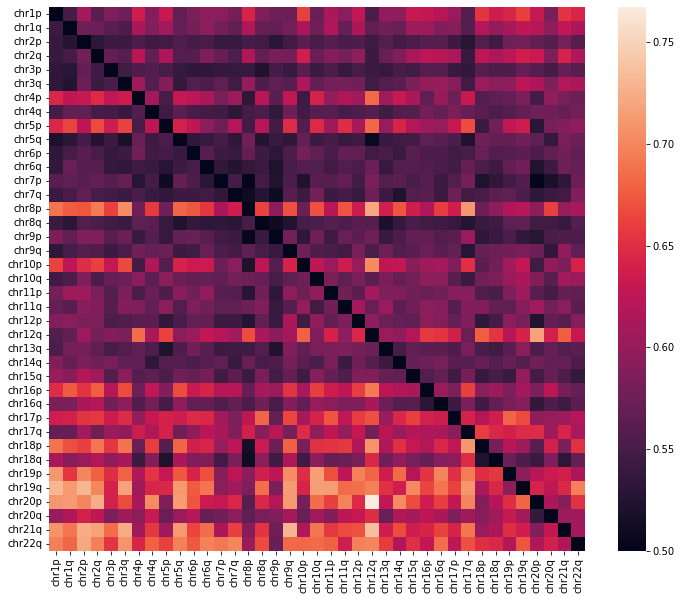

In [50]:
print("P(intra-arm cosine > inter) for each arm pair")
print("For each square, with-arm relationships for the row arm is being compared to ")
print("between-arm relationships when only building the map from the row arm and the column arm")

plt.figure(figsize=(12, 10))
sns.heatmap(no_cnv_pairs_bm_prob);

The horizontal stripes indicate that certain chromosome arms (e.g. chr8p) show high proximity bias regardless of which other arm they are paired with even when subsetting to cell lines with <1% CNVs on that arm pair. Also, the smaller arms (chr 16+) seem to mostly show higher proximity bias.

### Compute the same BM probabilities, but without filtering cell lines

In [51]:
def compute_bm_pair_no_filt(pair, dep_data=crispr_effect_cent):
    q = f'chromosome_arm in ["{pair[0]}", "{pair[1]}"]'
    pair_mat = make_pairwise_cos(dep_data.query(q))
    _, bm_arm = bm_metrics(pair_mat, verbose=False)

    return {pair: (bm_arm.loc[pair[0], "prob"], bm_arm.loc[pair[1], "prob"])}

In [52]:
%%time
with Pool(15) as p:
    result_no_filt = p.map(compute_bm_pair_no_filt, pairs)

CPU times: user 81.9 ms, sys: 326 ms, total: 408 ms
Wall time: 6min 28s


In [53]:
arm_pairs_bm_prob = pd.DataFrame(
    np.zeros(shape=(len(ARMS_ORD_NOX), len(ARMS_ORD_NOX))), index=ARMS_ORD_NOX, columns=ARMS_ORD_NOX
)

for d in result_no_filt:
    pair = list(d.keys())[0]
    arm1, arm2 = pair
    arm_pairs_bm_prob.loc[arm1, arm2] = d[pair][0]
    arm_pairs_bm_prob.loc[arm2, arm1] = d[pair][1]

np.fill_diagonal(arm_pairs_bm_prob.values, 0.5)

# Save
arm_pairs_bm_prob.to_parquet(os.path.join(path, "arm_pairs_bm_prob.pq"))

P(intra-arm cosine > inter) for each arm pair when not restriciting cell lines
For each square, with-arm relationships for the row arm is being compared to 
between-arm relationships when only building the map from the row arm and the column arm


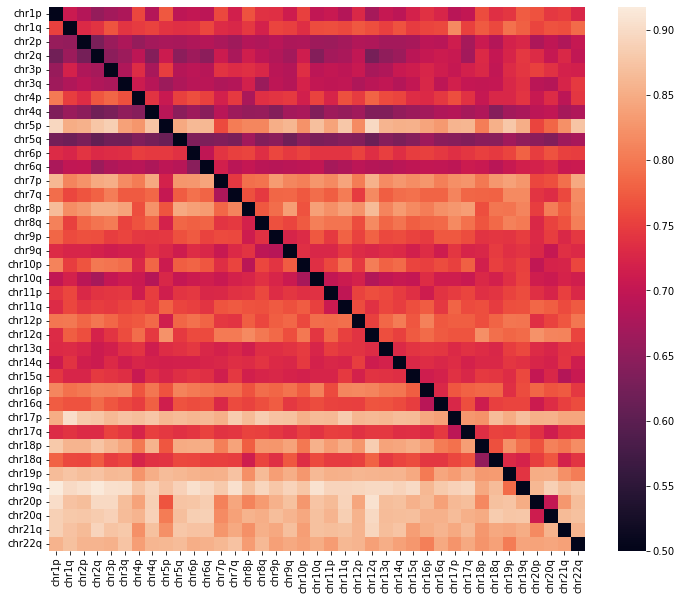

In [54]:
print("P(intra-arm cosine > inter) for each arm pair when not restriciting cell lines")
print("For each square, with-arm relationships for the row arm is being compared to ")
print("between-arm relationships when only building the map from the row arm and the column arm")
plt.figure(figsize=(12, 10))
sns.heatmap(arm_pairs_bm_prob);

Without filtering to cell lines with few CNVs, we still the horizontal stripes indicating that certain chromosome arms (e.g. chr5p) show high proximity bias regardless of which other arm they are paired with and that the smaller arms (chr 17+) mostly show higher proximity bias. This heatmap displays higher overall proximity bias suggesting that CNVs also contribute to the observed genome-wide effects. 

### Scatterplot of the values in the above heatmaps when subsetting cell lines vs using all the data

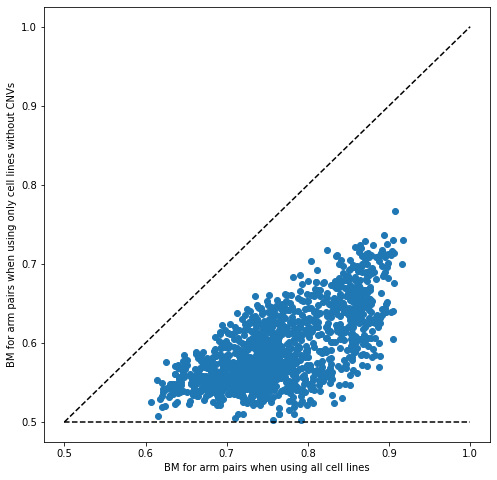

In [55]:
plt.figure(figsize=(8, 8))
plt.scatter(
    arm_pairs_bm_prob.values[np.where(~np.eye(arm_pairs_bm_prob.shape[0], dtype=bool))],
    no_cnv_pairs_bm_prob.values[np.where(~np.eye(no_cnv_pairs_bm_prob.shape[0], dtype=bool))],
)
plt.plot([0.5, 1], [0.5, 1], "--", c="k")
plt.plot([0.5, 1], [0.5, 0.5], "--", c="k")
plt.xlabel("BM for arm pairs when using all cell lines")
plt.ylabel("BM for arm pairs when using only cell lines without CNVs");

## Compare to RNAi data (when using all cell lines)
This should show minimal proximity bias

In [56]:
rnai_effect.index.name = "gene"
rnai_effect = add_chr_info(rnai_effect, gene_dict)
rnai_effect.iloc[:5, :5]

Full data has 12418 genes, 12043 of which are in annotations


,,,,ModelID,2313287_STOMACH,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,769P_KIDNEY,786O_KIDNEY,A2058_SKIN
gene,chromosome,chr_idx,chromosome_arm,gene_bp,,,,,
WASH7P,chr1,1,chr1p,14361,0.785467,0.696482,0.669828,0.329874,0.795572
NOC2L,chr1,1,chr1p,944202,-0.582235,-0.274340,-0.977824,-0.262599,-0.686026
KLHL17,chr1,1,chr1p,960583,-0.014862,-0.108350,0.011001,-0.033190,-0.014786
HES4,chr1,1,chr1p,998963,-0.125350,0.008219,-0.077151,-0.001733,0.031936
ISG15,chr1,1,chr1p,1013496,-0.046198,-0.059271,0.102319,0.087588,0.022938


In [57]:
rnai_effect_cent = rnai_effect.sub(rnai_effect.mean(axis=1), axis=0)

In [58]:
def compute_bm_pair_no_filt_rnai(pair, dep_data=rnai_effect_cent):
    q = f'chromosome_arm in ["{pair[0]}", "{pair[1]}"]'
    pair_mat = make_pairwise_cos(dep_data.query(q))
    _, bm_arm = bm_metrics(pair_mat, verbose=False)

    return {pair: (bm_arm.loc[pair[0], "prob"], bm_arm.loc[pair[1], "prob"])}

In [59]:
%%time
with Pool(15) as p:
    result_no_filt_rnai = p.map(compute_bm_pair_no_filt_rnai, pairs)

CPU times: user 72.9 ms, sys: 324 ms, total: 397 ms
Wall time: 4min 10s


In [60]:
arm_pairs_bm_prob_rnai = pd.DataFrame(
    np.zeros(shape=(len(ARMS_ORD_NOX), len(ARMS_ORD_NOX))), index=ARMS_ORD_NOX, columns=ARMS_ORD_NOX
)
for d in result_no_filt_rnai:
    pair = list(d.keys())[0]
    arm1, arm2 = pair
    arm_pairs_bm_prob_rnai.loc[arm1, arm2] = d[pair][0]
    arm_pairs_bm_prob_rnai.loc[arm2, arm1] = d[pair][1]

np.fill_diagonal(arm_pairs_bm_prob_rnai.values, 0.5)

# Save
arm_pairs_bm_prob_rnai.to_parquet(os.path.join(path, "arm_pairs_bm_prob_rnai.pq"))

P(intra-arm cosine > inter) in RNAi data for each arm pair when not restriciting cell lines
For each square, with-arm relationships for the row arm is being compared to 
between-arm relationships when only building the map from the row arm and the column arm


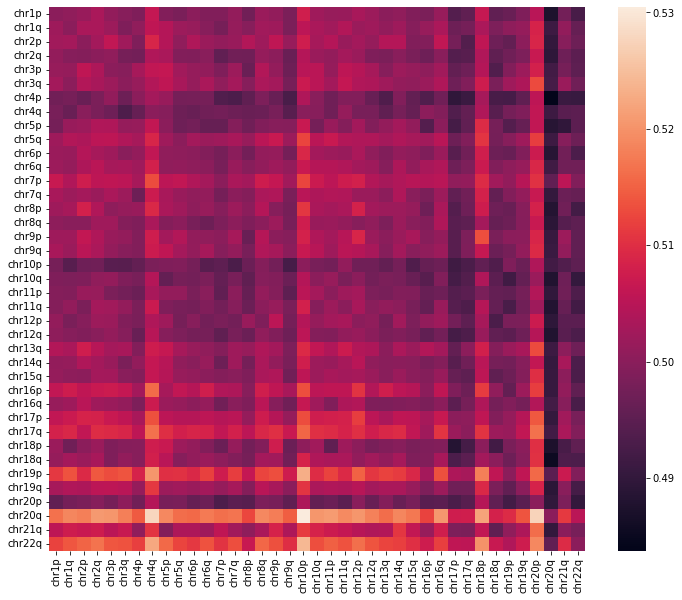

In [61]:
print("P(intra-arm cosine > inter) in RNAi data for each arm pair when not restriciting cell lines")
print("For each square, with-arm relationships for the row arm is being compared to ")
print("between-arm relationships when only building the map from the row arm and the column arm")
plt.figure(figsize=(12, 10))
sns.heatmap(arm_pairs_bm_prob_rnai);

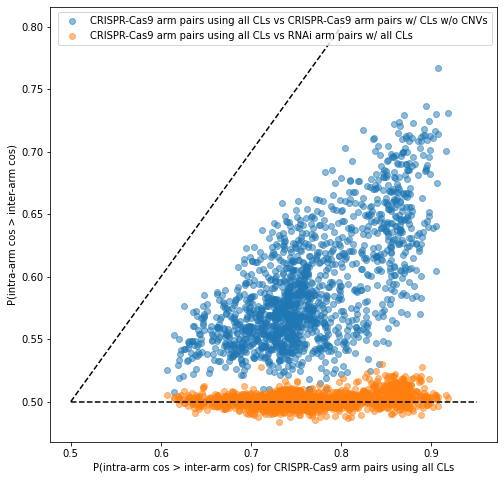

In [62]:
plt.figure(figsize=(8, 8))

arm_pairs_bm_prob_v = arm_pairs_bm_prob.values[np.where(~np.eye(arm_pairs_bm_prob.shape[0], dtype=bool))]
no_cnv_pairs_bm_prob_v = no_cnv_pairs_bm_prob.values[np.where(~np.eye(no_cnv_pairs_bm_prob.shape[0], dtype=bool))]
arm_pairs_bm_prob_rnai_v = arm_pairs_bm_prob_rnai.values[np.where(~np.eye(arm_pairs_bm_prob_rnai.shape[0], dtype=bool))]


plt.scatter(
    arm_pairs_bm_prob_v,
    no_cnv_pairs_bm_prob_v,
    alpha=0.5,
    label="CRISPR-Cas9 arm pairs using all CLs vs CRISPR-Cas9 arm pairs w/ CLs w/o CNVs",
)

plt.scatter(
    arm_pairs_bm_prob_v,
    arm_pairs_bm_prob_rnai_v,
    alpha=0.5,
    label="CRISPR-Cas9 arm pairs using all CLs vs RNAi arm pairs w/ all CLs",
)

plt.plot([0.5, 0.8], [0.5, 0.8], "--", c="k")
plt.plot([0.5, 0.95], [0.5, 0.5], "--", c="k")
plt.xlabel("P(intra-arm cos > inter-arm cos) for CRISPR-Cas9 arm pairs using all CLs")
plt.ylabel("P(intra-arm cos > inter-arm cos)")
plt.legend();

In [63]:
test_res = scipy.stats.mannwhitneyu(arm_pairs_bm_prob_v, no_cnv_pairs_bm_prob_v)
print("All CL vs <1% CNV CLs:  ", test_res)

test_res = scipy.stats.mannwhitneyu(no_cnv_pairs_bm_prob_v, arm_pairs_bm_prob_rnai_v)
print("CRISPR <1% CNV CLs vs RNAi:  ", test_res)

All CL vs <1% CNV CLs:   MannwhitneyuResult(statistic=2161886.0, pvalue=0.0)
CRISPR <1% CNV CLs vs RNAi:   MannwhitneyuResult(statistic=2193912.0, pvalue=0.0)


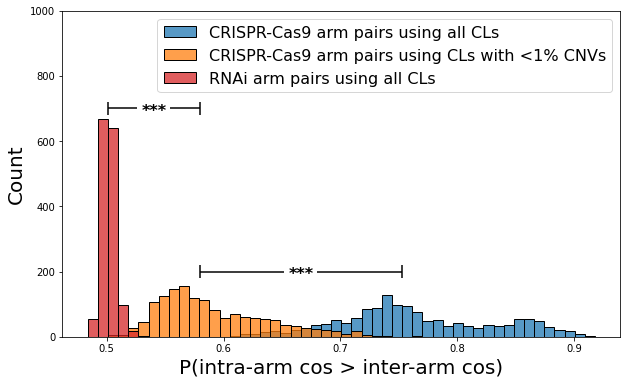

In [64]:
plt.figure(figsize=(10, 6))

m1 = np.median(arm_pairs_bm_prob_v)
m2 = np.median(no_cnv_pairs_bm_prob_v)
m3 = np.median(arm_pairs_bm_prob_rnai_v)

# Compute the bins
bins = np.histogram(np.hstack([arm_pairs_bm_prob_v, no_cnv_pairs_bm_prob_v, arm_pairs_bm_prob_rnai_v]), bins=50)[1]

# Use computed bins
sns.histplot(arm_pairs_bm_prob_v, color="C0", bins=bins, label="CRISPR-Cas9 arm pairs using all CLs")
sns.histplot(no_cnv_pairs_bm_prob_v, color="C1", bins=bins, label="CRISPR-Cas9 arm pairs using CLs with <1% CNVs")
sns.histplot(arm_pairs_bm_prob_rnai_v, color="C3", bins=bins, label="RNAi arm pairs using all CLs")
plt.ylim(0, 1000)
plt.ylabel("Count", fontsize=20)
plt.xlabel("P(intra-arm cos > inter-arm cos)", fontsize=20)

# add horizontal line
plt.hlines(y=700, xmin=m3, xmax=m2, color="k")
plt.hlines(y=200, xmin=m2, xmax=m1, color="k")

# add vertical lines
plt.vlines(x=[m3, m2], ymin=700 - 20, ymax=700 + 20, color="k")
plt.vlines(x=[m1, m2], ymin=200 - 20, ymax=200 + 20, color="k")

# add text
txt = lambda x, y: plt.text(
    x=x,
    y=y,
    s="***",
    horizontalalignment="center",
    fontdict={"fontsize": 16, "weight": "bold"},
    bbox=dict(facecolor="white", edgecolor="none"),
)
txt((m3 + m2) / 2, 700 - 20)
txt((m2 + m1) / 2, 200 - 20)

plt.legend(fontsize=16)
plt.gcf().set_facecolor("white")
plt.savefig(os.path.join(path, "DepMap_pb_arm_pairs.svg"), dpi=600, format="svg", bbox_inches="tight")

# Make a table of counts and probabilities 

In [67]:
no_cnv_pairs_n.iloc[:5, :5]

,chr1p,chr1q,chr2p,chr2q,chr3p
chr1p,0,160,188,161,149
chr1q,160,0,165,161,132
chr2p,188,165,0,238,178
chr2q,161,161,238,0,167
chr3p,149,132,178,167,0


In [97]:
cnv_table = pd.DataFrame(
    np.nan * np.ones(shape=(len(pairs), 7)),
    index=pd.MultiIndex.from_tuples(pairs),
    columns=[
        "n_cell_lines",
        "prob_arm1_all_cl_crispr",
        "prob_arm2_all_cl_crispr",
        "prob_arm1_no_cnv_cl_crispr",
        "prob_arm2_no_cnv_cl_crispr",
        "prob_arm1_all_cl_rnai",
        "prob_arm2_all_cl_rnai",
    ],
)

for arm1, arm2 in pairs:
    cnv_table.loc[(arm1, arm2), "n_cell_lines"] = no_cnv_pairs_n.loc[arm1, arm2]

    cnv_table.loc[(arm1, arm2), "prob_arm1_all_cl_crispr"] = arm_pairs_bm_prob.loc[arm1, arm2]
    cnv_table.loc[(arm1, arm2), "prob_arm2_all_cl_crispr"] = arm_pairs_bm_prob.loc[arm2, arm1]

    cnv_table.loc[(arm1, arm2), "prob_arm1_no_cnv_cl_crispr"] = no_cnv_pairs_bm_prob.loc[arm1, arm2]
    cnv_table.loc[(arm1, arm2), "prob_arm2_no_cnv_cl_crispr"] = no_cnv_pairs_bm_prob.loc[arm2, arm1]

    cnv_table.loc[(arm1, arm2), "prob_arm1_all_cl_rnai"] = arm_pairs_bm_prob_rnai.loc[arm1, arm2]
    cnv_table.loc[(arm1, arm2), "prob_arm2_all_cl_rnai"] = arm_pairs_bm_prob_rnai.loc[arm2, arm1]

cnv_table.to_csv(os.path.join(path, "cnv_stats.csv"))
cnv_table

n_cell_lines  prob_arm1_all_cl_crispr  prob_arm2_all_cl_crispr  \
chr1p  chr1q          160.0                 0.707461                 0.751447   
       chr2p          188.0                 0.685255                 0.657261   
       chr2q          161.0                 0.655272                 0.621374   
       chr3p          149.0                 0.668262                 0.658991   
       chr3q          156.0                 0.678471                 0.665060   
...                     ...                      ...                      ...   
chr20p chr21q         214.0                 0.828251                 0.816486   
       chr22q         179.0                 0.867478                 0.840921   
chr20q chr21q         202.0                 0.864706                 0.856151   
       chr22q         158.0                 0.870689                 0.844059   
chr21q chr22q         209.0                 0.858767                 0.838673   

               prob_arm1_no_cnv_cl_crispr  prob_arm2_no_cnv_cl_crispr  \
chr1p  chr1q                     0.548505                    0.543611   
       chr2p                     0.607596                    0.537843   
       chr2q                     0.560860                    0.538076   
       chr3p                     0.585401                    0.533640   
       chr3q                     0.575172                    0.532827   
...                                   ...                         ...   
chr20p chr21q                    0.591335                    0.588393   
       chr22q                    0.652328                    0.616556   
chr20q chr21q                    0.605022                    0.627918   
       chr22q                    0.605294                    0.638966   
chr21q chr22q                    0.608021                    0.616054   

               prob_arm1_all_cl_rnai  prob_arm2_all_cl_rnai  
chr1p  chr1q                0.500624               0.502013  
       chr2p                0.501558               0.502444  
       chr2q                0.503398               0.501023  
       chr3p                0.500726               0.501441  
       chr3q                0.499668               0.502661  
...                              ...                    ...  
chr20p chr21q               0.498617               0.516065  
       chr22q               0.490118               0.518831  
chr20q chr21q               0.511184               0.490100  
       chr22q               0.505196               0.495522  
chr21q chr22q               0.498050               0.509556  

[741 rows x 7 columns]